# Draft 1 - Figure 2

_Description of our goal:_  

a. Cone plots in select regions with obs. unc. to ICV unc. ratio, b. trends zeroed to ToE, and maybe c. evolution of obs. Unc.

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

from functions import (
    to_png
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define functions

In [2]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

In [3]:
def percentile_vec(data,core_dim:str,q,**kwargs):
    
    data_chunk = data.chunk({core_dim:-1}) # needed!

    res_out = xr.apply_ufunc(np.nanpercentile,              # Function to apply
                             data_chunk,                      # Positional arguments for the function
                             input_core_dims=[[core_dim]],    # Dimension(s) to apply the function over
                             kwargs={**{'q':q}, **kwargs},                   # Keyword arguments for the function
                             # kwargs=kwargs,                   # Keyword arguments for the function
                             dask="parallelized",             # These may be necessary for efficient use via dask.
                             output_dtypes=['float64'],
                             vectorize = True)                # Vectorize
    
    return res_out


# You can also do this in numpy if you are ok converting back to xarray
# out_np = np.nanpercentile(data,q=95,axis=1,keepdims=False)

### Load trend data processed for IPCC Regions

#### Models

In [4]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/'
mpi_dir         = 'MPI-GE/'
canesm2_dir     = 'CanESM2/'
esm2m_dir       = 'ESM2M/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [5]:
cesm1_trends_filepath   = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_trends_filepath     = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_trends_filepath = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_trends_filepath   = glob.glob('%s/%s/*.trends*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [6]:
cesm1_pic_trends_all   = xr.open_dataarray(*cesm1_trends_filepath)

mpi_pic_trends_all     = xr.open_dataarray(*mpi_trends_filepath)

canesm2_pic_trends_all = xr.open_dataarray(*canesm2_trends_filepath)

esm2m_pic_trends_all   = xr.open_dataarray(*esm2m_trends_filepath)

#### Observations

In [7]:
obs_tseries_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/'
# gistemp_2x2_dir = 'GISTEMP_2x2/'
gistemp_5x5_dir = 'GISTEMP_5x5/'
hadcrut5_dir    = 'HadCRUT5/'

In [8]:
gistemp_tas_var = 'tempAnom'
hadcrut5_tas_var = 'tas'

In [9]:
# gistemp_2x2_trends_filepath  = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,gistemp_2x2_dir))
gistemp_5x5_trends_filepath  = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_trends_filepath     = glob.glob('%s/%s/*trends*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load the trend data

In [10]:
# gistemp_2x2_trends_all  = xr.open_dataarray(*gistemp_2x2_trends_filepath)

gistemp_5x5_trends_all  = xr.open_dataarray(*gistemp_5x5_trends_filepath)

hadcrut5_trends_all     = xr.open_dataarray(*hadcrut5_trends_filepath)

In [11]:
# gistemp_2x2_trends_1960 = gistemp_2x2_trends_all.sel(startyear=1960)
gistemp_5x5_trends_1960 = gistemp_5x5_trends_all.sel(startyear=1960)
hadcrut5_trends_1960    = hadcrut5_trends_all.sel(startyear=1960)

In [12]:
# Compute the low and high bounds on the trends from the observational products

# GISTEMP 2x2
# gistemp_2x2_trends_2_5perc  = percentile_vec(gistemp_2x2_trends_1960,q=2.5,core_dim='record')
# gistemp_2x2_trends_50perc  = percentile_vec(gistemp_2x2_trends_1960,q=50,core_dim='record')
# gistemp_2x2_trends_97_5perc = percentile_vec(gistemp_2x2_trends_1960,q=97.5,core_dim='record')

# GISTEMP 5x5
gistemp_5x5_trends_2_5perc  = percentile_vec(gistemp_5x5_trends_1960,q=2.5,core_dim='record').compute()
gistemp_5x5_trends_50perc  = percentile_vec(gistemp_5x5_trends_1960,q=50,core_dim='record').compute()
gistemp_5x5_trends_97_5perc = percentile_vec(gistemp_5x5_trends_1960,q=97.5,core_dim='record').compute()

# HadCRUT5
hadcrut5_trends_2_5perc  = percentile_vec(hadcrut5_trends_1960,q=2.5,core_dim='realization').compute()
hadcrut5_trends_50perc  = percentile_vec(hadcrut5_trends_1960,q=50,core_dim='realization').compute()
hadcrut5_trends_97_5perc = percentile_vec(hadcrut5_trends_1960,q=97.5,core_dim='realization').compute()

In [13]:
# CESM1
cesm1_pic_trends_2_5perc  = percentile_vec(cesm1_pic_trends_all,q=2.5,core_dim='startyear').compute()
cesm1_pic_trends_97_5perc = percentile_vec(cesm1_pic_trends_all,q=97.5,core_dim='startyear').compute()

# MPI-GE
mpi_pic_trends_2_5perc  = percentile_vec(mpi_pic_trends_all,q=2.5,core_dim='startyear').compute()
mpi_pic_trends_97_5perc = percentile_vec(mpi_pic_trends_all,q=97.5,core_dim='startyear').compute()

# CanESM2
canesm2_pic_trends_2_5perc  = percentile_vec(canesm2_pic_trends_all,q=2.5,core_dim='startyear').compute()
canesm2_pic_trends_97_5perc = percentile_vec(canesm2_pic_trends_all,q=97.5,core_dim='startyear').compute()

# ESM2M
esm2m_pic_trends_2_5perc  = percentile_vec(esm2m_pic_trends_all,q=2.5,core_dim='startyear').compute()
esm2m_pic_trends_97_5perc = percentile_vec(esm2m_pic_trends_all,q=97.5,core_dim='startyear').compute()

### Code for making Cone Plots

Do this for regions that show a large delay (do I just pick a subset of these? 6 is a lot):  

- E. and W. Antarctica (44,45)  

- S. Australia (42)  

- S.W. South America (13)  

- N. Eastern-Africa (23)  

- N.W. South-America (9)  


#### All relevant cone plots at once

Also, add the ratio of the observation uncertainty to the model ICV uncertainty so we can test both departures from the Leroy assumptions in this figure.

In [14]:
cesm1_pic_95confspread   = cesm1_pic_trends_97_5perc - cesm1_pic_trends_2_5perc
gistemp_5x5_95confspread = gistemp_5x5_trends_97_5perc - gistemp_5x5_trends_2_5perc

The last year of the trend is given by:  

$$ t_{last-year} = t_{start-year} + t_{duration} - 1 $$

This can be seen by reorganizing to get:  

$$ t_{duration} = t_{last-year} - t_{start-year} + 1 $$

The added $1$ is just because the start and end years of the trend are inclusive. E.g. A record starting in 1960 and ending in 1965 lasts 6 years.

In [15]:
# Compute the mean and strict ToEs.
# NOTE: I don't need to subtract 1 year here because I calculate the last duration before the PIC uncertainty is exceeded. 
# So to get to the next year when the duration is exceeded I would need to add 1, which cancels out with the -1.
year_gistemp = 1960 + gistemp_5x5_trends_2_5perc.duration - 1
year_cesm1   = 1960 + cesm1_pic_trends_2_5perc.duration - 1

mean_tte_bool = gistemp_5x5_trends_50perc > cesm1_pic_trends_97_5perc
mean_tte      = 1960 + mean_tte_bool.duration.where(~mean_tte_bool).max(dim='duration')
mean_tte.load()[mean_tte==2020] = np.nan

true_tte_bool = gistemp_5x5_trends_2_5perc > cesm1_pic_trends_97_5perc
true_tte      = 1960 + true_tte_bool.duration.where(~true_tte_bool).max(dim='duration')
true_tte.load()[true_tte==2020] = np.nan

cesm1_pic_95confspread   = cesm1_pic_trends_97_5perc - cesm1_pic_trends_2_5perc
gistemp_5x5_95confspread = gistemp_5x5_trends_97_5perc - gistemp_5x5_trends_2_5perc

gistemp_cesm1_uncratio = gistemp_5x5_95confspread / cesm1_pic_95confspread

Re-index by years since emergence

In [16]:
gistemp_5x5_trends_50perc_reindex = gistemp_5x5_trends_50perc.copy()
reindexed_trends = []

for region_index in gistemp_5x5_trends_50perc_reindex.RegionIndex:

    region_trends = gistemp_5x5_trends_50perc_reindex.sel(RegionIndex=region_index)
    region_mean_tte = mean_tte.sel(RegionIndex=region_index)
    
    region_trends['years_since_emerge'] = 1960 + region_trends.duration - 1 - region_mean_tte
    
    reindexed_trends.append(region_trends)    

reindexed_trends_concat = xr.concat(reindexed_trends,dim='RegionIndex')

In [17]:
mean_delay_trends = []

for delay in range(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max())):
    
    delay_mean_value = reindexed_trends_concat.where(reindexed_trends_concat.years_since_emerge==delay).mean()
    
    mean_delay_trends.append(delay_mean_value.values)

delay_range = np.arange(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max()))

delay_da = xr.DataArray(
    data=mean_delay_trends,
    dims=["delay",],
    coords={'delay':delay_range}
)

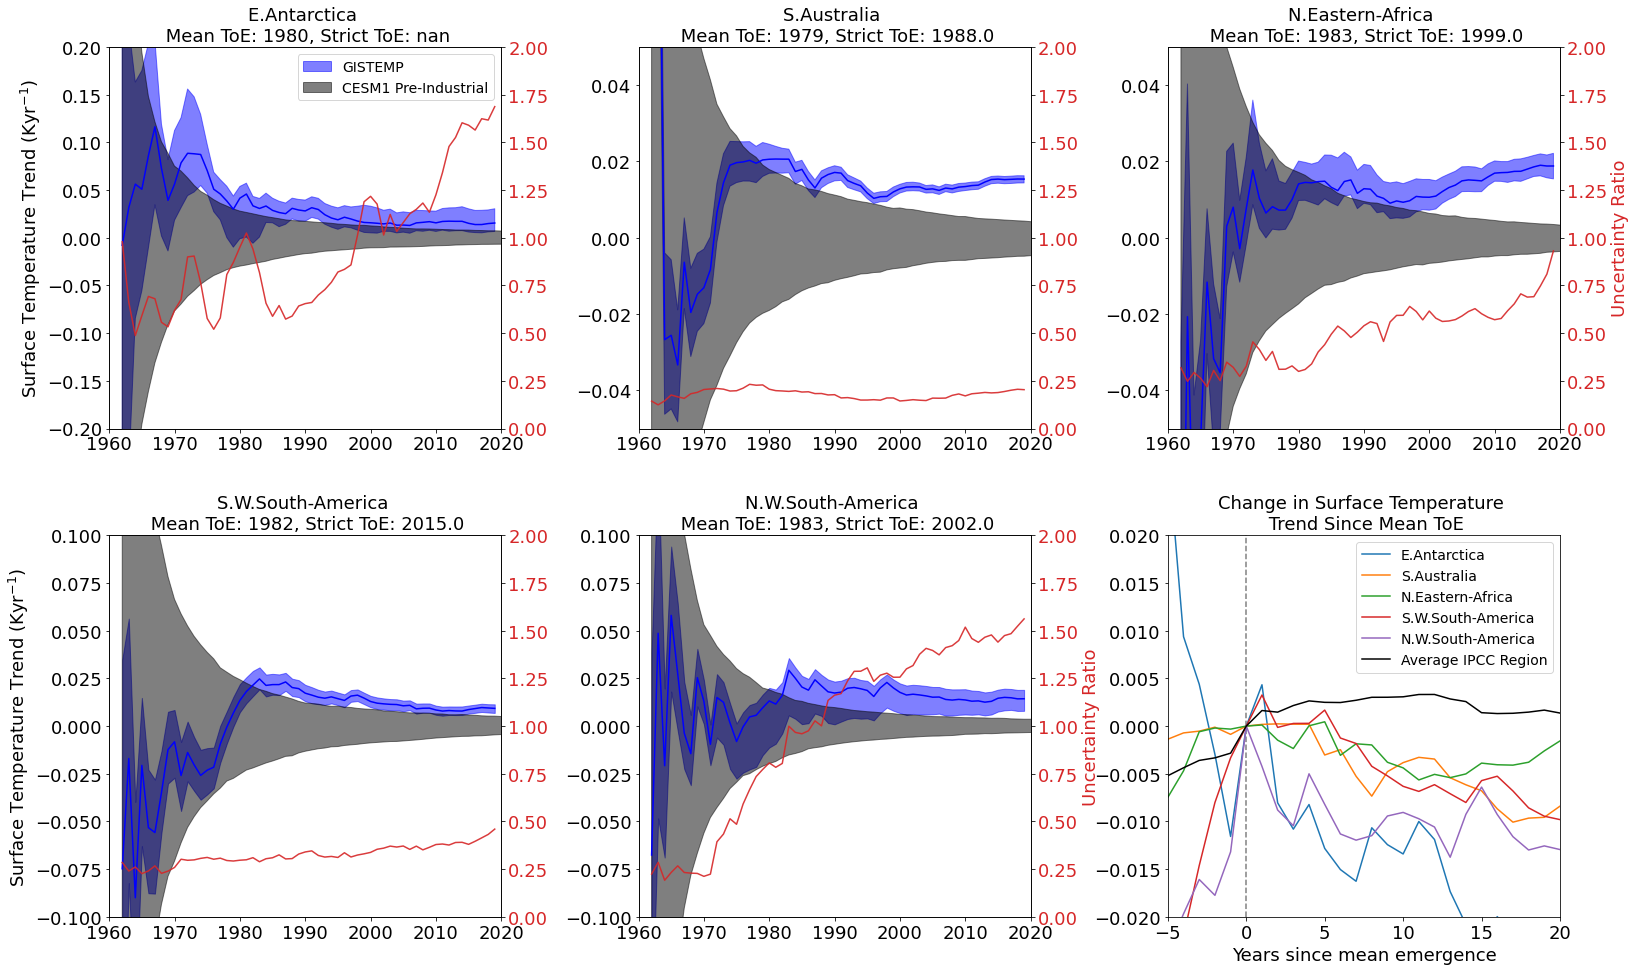

In [18]:
fig,axs = plt.subplots(2,3,figsize=(26,16))
axs = axs.flat

fig.subplots_adjust(hspace=0.28,wspace=0.35)

# Set values here:
region_indices = [44,42,23,13,9]
region_ylims   = [[-0.2,0.2],[-0.05,0.05],[-0.05,0.05],[-0.1,0.1],[-0.1,0.1],]

axs2 = []

for region_index,ylim,ax in zip(region_indices,region_ylims,axs):
    
    # Compute the mean and strict ToEs
    _mean_tte      = mean_tte.sel(RegionIndex=region_index)
    _true_tte      = true_tte.sel(RegionIndex=region_index)
    _gistemp_cesm1_uncratio = gistemp_cesm1_uncratio.sel(RegionIndex=region_index)
    
    if (_true_tte == 2020): _true_tte = np.nan #xr.where(part_undef_gistemp,2020 - mean_tte_gistemp,np.nan)

    ax.fill_between(year_gistemp,
                    gistemp_5x5_trends_2_5perc.sel(RegionIndex=region_index),
                    gistemp_5x5_trends_97_5perc.sel(RegionIndex=region_index),
                    color='blue',
                    alpha=0.5,
                    label='GISTEMP',
                   )

    ax.fill_between(year_cesm1,
                    cesm1_pic_trends_2_5perc.sel(RegionIndex=region_index),
                    cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index),
                    color='black',
                    alpha=0.5,
                    label='CESM1 Pre-Industrial',
                   )

    ax.plot(year_gistemp,
            gistemp_5x5_trends_50perc.sel(RegionIndex=region_index),
            color='blue'
           )

    ax.tick_params(axis='both', labelsize=18)

    # ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)
    # ax.set_xlabel('Year',fontsize=18)

    ax.set_xlim(1960,2020)
    # ax.set_xlim(1963,2020)
    ax.set_ylim(ylim)
    
    # Set up another y-axis on the right side of the plot
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    # ax2.set_ylabel('Uncertainty Ratio', color=color,fontsize=18)  # we already handled the x-label with ax1
    ax2.plot(1960+gistemp_cesm1_uncratio.duration - 1, _gistemp_cesm1_uncratio, color=color,alpha=0.9)#,linestyle='dashed')
    ax2.set_ylim([0,2])
    ax2.tick_params(axis='y', labelcolor=color,labelsize=18)        

    title_p1 = str(gistemp_5x5_trends_2_5perc.sel(RegionIndex=region_index).RegionName.values)
    title_p2 = 'Mean ToE: %d, Strict ToE: %s' % (_mean_tte.values,_true_tte.values)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %d' % (mean_tte,true_tte)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %s' % (mean_tte,str(np.round(true_tte.values,0)))

    ax.set_title('%s \n %s' % (title_p1,title_p2),fontsize=18)
    
    axs2.append(ax2)

axs[0].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)
axs[3].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)

axs2[2].set_ylabel('Uncertainty Ratio', color=color,fontsize=18)
axs2[4].set_ylabel('Uncertainty Ratio', color=color,fontsize=18)
# axs2[5].set_ylabel('Uncertainty Ratio', color=color,fontsize=18)

axs[0].legend(fontsize=14)
    
for region_index in region_indices:
    
    # Plot the trends shifted to the time of emergence
    region_trends = gistemp_5x5_trends_50perc.sel(RegionIndex=region_index) # Select region
    region_mean_tte = mean_tte.sel(RegionIndex=region_index) # Get ToE
    duration_at_emergence = region_mean_tte-1960+1 # Get the duration of trends at ToE
    region_trends_corrected = region_trends - region_trends.sel(duration=duration_at_emergence) # shift the trends to the ToE year
            
    # Correct for the trends changing 
    year_from_toe = 1960 + region_trends_corrected.duration - 1 # shift the year to the ToE year
    axs[5].plot(year_from_toe - region_mean_tte,region_trends_corrected,label=region_trends_corrected.RegionName.values)    

axs[5].plot(delay_da.delay,delay_da-delay_da.sel(delay=0),color='black',label='Average IPCC Region')
    
axs[5].vlines(0,-0.02,0.05,color='grey',linestyle='dashed',zorder=-1)
axs[5].set_xlim(-5,20)
axs[5].set_ylim(-0.02,0.02)

axs[5].set_xlabel('Years since mean emergence',fontsize=18)
# axs[5].set_ylabel('Change in Surface Temperature Trend Since Emergence (Kyr$^{-1}$)',fontsize=18)
axs[5].set_title('Change in Surface Temperature \n Trend Since Mean ToE',fontsize=18)
axs[5].tick_params(axis='both',labelsize=18)        

axs[5].legend(fontsize=14)

In [33]:
to_png(file=fig,filename='draft1_fig2_cones',dpi=300,ext='png',bbox_inches='tight') # or .pdf 